Explaining and Harnessing Adversarial Examples - https://arxiv.org/pdf/1412.6572.pdf

Código Base - https://www.tensorflow.org/tutorials/generative/adversarial_fgsm

In [ ]:
import numpy as np
np.random.seed(1)
import tensorflow as tf
tf.random.set_seed(2)

import seaborn as sns
import matplotlib.pyplot as plt

from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras import Input

sns.set()

In [ ]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()
print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

#colocando no intervalo [0-1]
x_train = x_train/ 255.0
x_test = x_test/ 255.0

#aplicando o one-hot-encoding
y_train = tf.keras.utils.to_categorical(y_train, 10)
y_test = tf.keras.utils.to_categorical(y_test, 10)

#adcionando uma dimensão extra 
x_train = x_train.reshape(-1, 28, 28, 1)
x_test = x_test.reshape(-1, 28, 28, 1)
print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

4423680/4422102 [==============================] - 0s 0us/step
(60000, 28, 28) (60000,) (10000, 28, 28) (10000,)
(60000, 28, 28, 1) (60000, 10) (10000, 28, 28, 1) (10000, 10)


In [ ]:
dict_label = {
0 : 'T-shirt/top',
1 : 'Trouser',
2 : 'Pullover',
3 :	'Dress',
4 :	'Coat',
5 :	'Sandal',
6 :	'Shirt',
7 :	'Sneaker',
8 :	'Bag',
9 :	'Ankle boot'
}

In [ ]:
model = Sequential()
model.add(Input(shape=(28, 28, 1)))
model.add(Conv2D(32, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(64, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Flatten())
model.add(Dense(10, activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 1600)              0         
_________________________________________________________________
dense (Dense)                (None, 10)                16010     
Total params: 34,826
Trainable params: 34,826
Non-trainable params: 0
____________________________________________________

In [ ]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics='accuracy')
log = model.fit(x_train, y_train, batch_size=32, epochs=10, validation_split=0.2)

Epoch 1/10
1500/1500 [==============================] - 4s 3ms/step - loss: 0.5081 - accuracy: 0.8171 - val_loss: 0.3683 - val_accuracy: 0.8666
Epoch 2/10
1500/1500 [==============================] - 4s 3ms/step - loss: 0.3513 - accuracy: 0.8741 - val_loss: 0.3482 - val_accuracy: 0.8739
Epoch 3/10
1500/1500 [==============================] - 4s 3ms/step - loss: 0.3060 - accuracy: 0.8900 - val_loss: 0.3122 - val_accuracy: 0.8838
Epoch 4/10
1500/1500 [==============================] - 4s 3ms/step - loss: 0.2741 - accuracy: 0.9004 - val_loss: 0.3115 - val_accuracy: 0.8816
Epoch 5/10
1500/1500 [==============================] - 4s 3ms/step - loss: 0.2552 - accuracy: 0.9072 - val_loss: 0.2995 - val_accuracy: 0.8915
Epoch 6/10
1500/1500 [==============================] - 4s 3ms/step - loss: 0.2335 - accuracy: 0.9150 - val_loss: 0.2968 - val_accuracy: 0.8947
Epoch 7/10
1500/1500 [==============================] - 4s 3ms/step - loss: 0.2180 - accuracy: 0.9200 - val_loss: 0.2830 - val_accuracy:

In [ ]:
print(f'Test accuracy: {model.evaluate(x_test, y_test, verbose=0)[1]:.3f}')

Test accuracy: 0.898


In [ ]:
def fast_gradient_sign(image, label):
    
    image = tf.cast(image, tf.float32)
    
    with tf.GradientTape() as tape:
        tape.watch(image)
        prediction = model(image)
        loss = tf.keras.losses.categorical_crossentropy(label, prediction)
    
    gradient = tape.gradient(loss, image)
    signed_grad = tf.sign(gradient)
    
    return signed_grad

In [ ]:
x_adv = x_test.copy()

for idx in range(len(x_adv)):

    yi_true = np.expand_dims(y_test[idx], axis=0)
    xi_adv = np.expand_dims(x_adv[idx], axis=0)

    xi_grad = fast_gradient_sign(xi_adv, yi_true).numpy()
    xi_grad = np.squeeze(xi_grad, axis=0)
    x_adv[idx] += xi_grad * 0.05

x_adv = np.clip(x_adv, 0, 1)

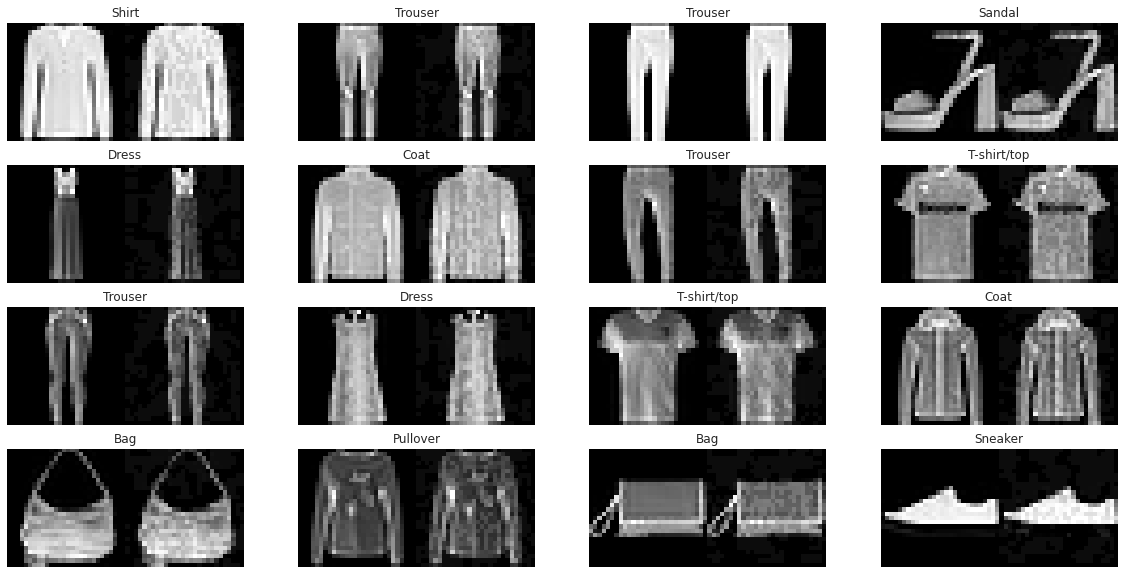

In [ ]:
np.random.seed(1)
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(20, 10))
idx_array = np.random.choice(np.arange(len(x_test)), size=32, replace=False)

for ax, idx in zip(axes.flat, idx_array):

    yi_true = y_test[idx]
    xi_adv = x_adv[idx]
    xi_test = x_test[idx]
    img = np.concatenate((xi_test, xi_adv), axis=1)

    ax.imshow(img.squeeze(-1), cmap='gray')
    ax.set_title(f'{dict_label[np.argmax(yi_true)]}')
    ax.axis('off')
    
plt.show()

In [ ]:
acc = model.evaluate(x_adv, y_test, verbose=0)[1]
print(f'Test accuracy after adversarial attack: {acc:.3f}')

Test accuracy after adversarial attack: 0.179


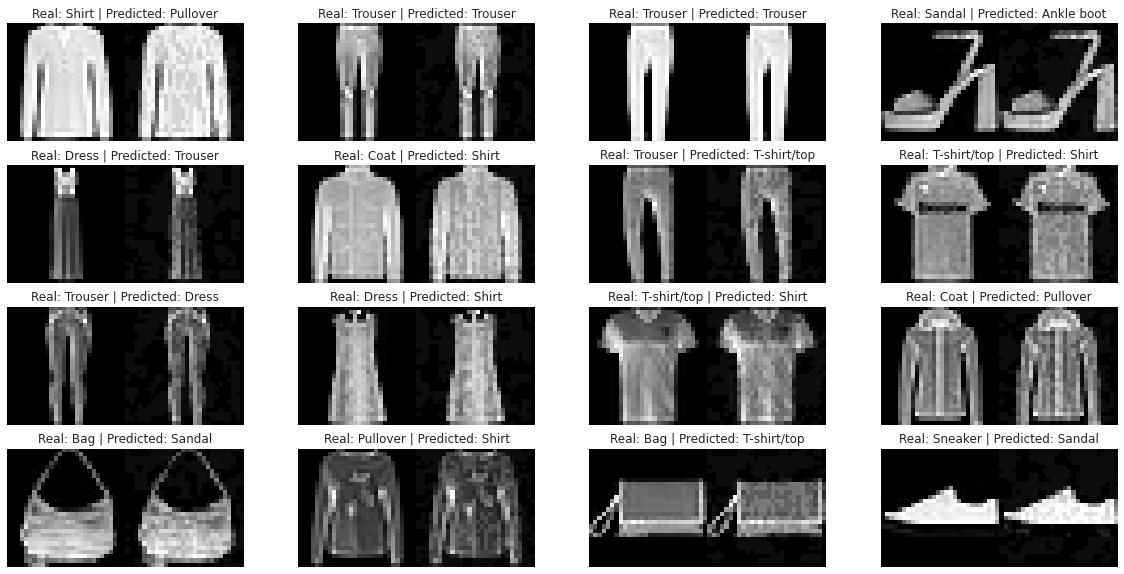

In [ ]:
np.random.seed(1)
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(20, 10))
idx_array = np.random.choice(np.arange(len(x_test)), size=32, replace=False)

for ax, idx in zip(axes.flat, idx_array):

    yi_true = y_test[idx]
    xi_adv = x_adv[idx]
    xi_test = x_test[idx]
    img = np.concatenate((xi_test, xi_adv), axis=1)
    xi_adv = np.expand_dims(x_adv[idx], axis=0)

    ax.imshow(img.squeeze(-1), cmap='gray')

    y_true_label = dict_label[np.argmax(yi_true)]
    y_pred_label = dict_label[np.argmax(model.predict(xi_adv))]

    title = f'Real: {y_true_label} | Predicted: {y_pred_label}'
    ax.set_title(title)
    ax.axis('off')
    
plt.show()